In [2]:
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
from pprint import pprint
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def transform_calc(current_len:int, prev_len:int) -> str:

  percent = current_len*100/prev_len
  return f'The current data frame is {percent:.2f}% of the initial size prior to transformation . There were {prev_len} rows and now there are {current_len} rows, with {prev_len - current_len} removed'

# 1. Data Preperation

Columns in historical_data.csv
1. **Time features**

  a. **market_id**: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id

  b. **created_at**: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
  
  c. **actual_delivery_time**: Timestamp in UTC when the order was delivered to the consumer


2. **Store features**

  a. **store_id**: an id representing the restaurant the order was submitted for

  b. **store_primary_category**: cuisine category of the restaurant, e.g., italian, asian

  c. **order_protocol**: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

3. **Order features**

  a. **total_items**: total number of items in the order

  b. **subtotal**: total value of the order submitted (in cents)

  c. **num_distinct_items**: number of distinct items included in the order

  d. **min_item_price**: price of the item with the least cost in the order (in cents)

  e. **max_item_price**: price of the item with the highest cost in the order (in cents)

4. **Market features**: DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

  a. **total_onshift_dashers**: Number of available dashers who are within 10 miles of the store at the time of order creation

  b. **total_busy_dashers**: Subset of above total_onshift_dashers who are currently working on an order

  c. **total_outstanding_orders**: Number of orders within 10 miles of this order that are currently being processed.


5. **Predictions from other models**: We have predictions from other models for various stages of delivery process that we can use:

  a. **estimated_order_place_duration**: Estimated time for the restaurant to receive the order from DoorDash (in seconds)

  b. **estimated_store_to_consumer_driving_duration**: Estimated travel time between store and consumer (in seconds)

6. **Practicalities**: Build a model to predict the total delivery duration seconds (as defined above). Feel free to generate additional features from the given data to improve model performance. Explain:

  * model(s) used,
  * how you evaluated your model performance on the historical data
  * any data processing you performed on the data
  * feature engineering choices you made
  * other information you would like to share your modeling approach

## a. load data and format data

In [7]:
df = pd.read_csv('/content/drive/My Drive/Door_dash_delivery_data/cleaned_data.csv')
if 'Unnamed: 0' in df.columns:
  df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,order_time,market_id,created_at_hour,total_items,subtotal,estimated_store_to_consumer_driving_duration,total_outstanding_orders,estimated_order_place_duration
0,62.0,1.0,22.0,4.0,3441.0,14.350000,21.0,7.433333
1,67.0,2.0,21.0,1.0,1900.0,11.500000,2.0,7.433333
2,29.0,3.0,20.0,1.0,1900.0,11.500000,0.0,7.433333
3,39.0,3.0,2.0,3.0,3900.0,10.833333,9.0,7.433333
4,38.0,3.0,20.0,3.0,5000.0,5.633333,2.0,7.433333


## b. Train Test Split

In [8]:
X = df.drop(columns=['order_time'])
Y = pd.DataFrame(df['order_time'])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# 2. create a cross validation function to find most optimal tree depth

In [10]:
def run_cross_validation_on_trees(X: pd.DataFrame, Y: pd.DataFrame, tree_depth: list, cross_validation=5, scoring= 'neg_root_mean_squared_error') -> dict:
  scores_dict = {'cv_scores_list':[], 'cv_scores_std':[], 'cv_scores_mean':[], 'accuracy_scores':[]}
  for depth in tree_depth:
    tree_model = DecisionTreeRegressor(max_depth=depth)
    cv_scores = cross_val_score(tree_model, X, Y, cv=cross_validation, scoring=scoring)
    scores_dict['cv_scores_list'].append(cv_scores)
    scores_dict['cv_scores_mean'].append(cv_scores.mean())
    scores_dict['cv_scores_std'].append(cv_scores.std())
    scores_dict['accuracy_scores'].append(tree_model.fit(X, Y).score(X, Y))
  scores_dict.pop('cv_scores_list')
  scores_dict['cv_scores_mean'] = np.array(scores_dict['cv_scores_mean'])
  scores_dict['cv_scores_std'] = np.array(scores_dict['cv_scores_std'])
  scores_dict['accuracy_scores'] = np.array(scores_dict['accuracy_scores'])
  return scores_dict

In [15]:
def plot_cross_validation_on_trees(tree_depth: list, scores_dict: dict, title: str) -> None:
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(tree_depth, scores_dict['cv_scores_mean'], '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(tree_depth, scores_dict['cv_scores_mean']-3.5*scores_dict['cv_scores_std'], scores_dict['cv_scores_mean']+3.5*scores_dict['cv_scores_std'], alpha=0.2)
    ylim = plt.ylim()
    ax.plot(tree_depth, scores_dict['accuracy_scores'], '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.grid()
    ax.set_xticks(tree_depth)
    ax.legend()

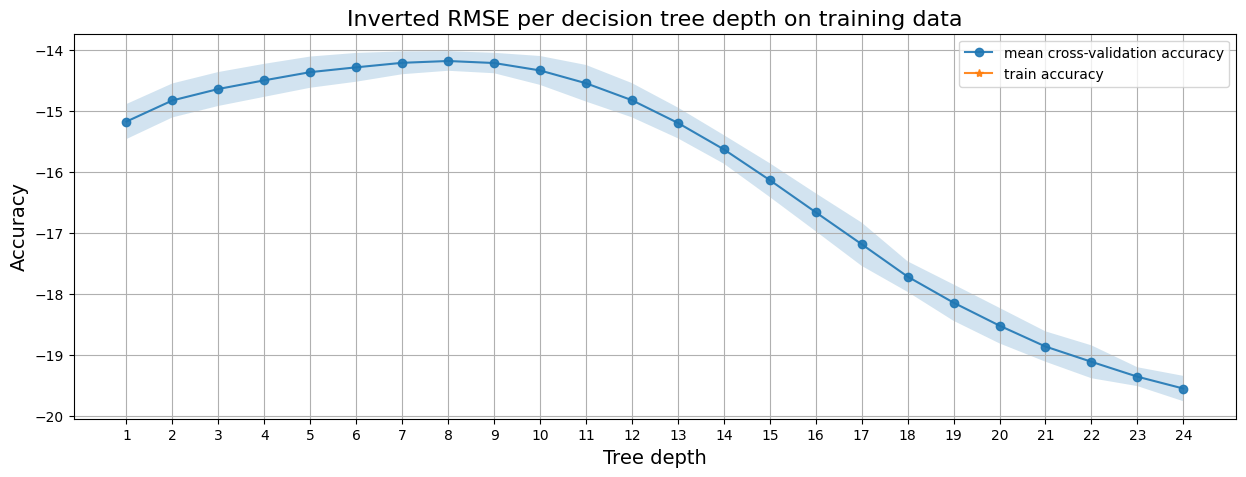

In [16]:
dd_tree_depths = range(1,25)
dd_scores_dict = run_cross_validation_on_trees(x_train, y_train, dd_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(dd_tree_depths, dd_scores_dict, 'Inverted RMSE per decision tree depth on training data')

# 3. Finalise and create a model to save

## a. Fit Data to Dtree

In [19]:
decision_tree = DecisionTreeRegressor(max_depth=8)
decision_tree = decision_tree.fit(x_train, y_train)

## b. Predict Using Tree

In [29]:
y_pred = decision_tree.predict(x_test)
print('+---------------------------+')
print('|Observed     |    Predicted|')
for observed, predicted in zip(list(y_test['order_time']), y_pred):
  print(f'|{observed:.2f}     |    {predicted:.2f}|')


Streaming output truncated to the last 5000 lines.
|50.00     |    49.85|
|55.00     |    39.81|
|35.00     |    46.42|
|41.00     |    46.00|
|47.00     |    50.61|
|52.00     |    41.37|
|33.00     |    54.93|
|35.00     |    34.59|
|44.00     |    51.92|
|35.00     |    33.88|
|20.00     |    38.26|
|51.00     |    39.13|
|41.00     |    48.03|
|57.00     |    36.55|
|43.00     |    39.13|
|48.00     |    46.07|
|50.00     |    51.92|
|52.00     |    54.93|
|31.00     |    48.94|
|26.00     |    39.86|
|46.00     |    42.00|
|57.00     |    46.52|
|40.00     |    52.81|
|68.00     |    46.66|
|19.00     |    34.59|
|30.00     |    44.08|
|37.00     |    45.03|
|58.00     |    45.27|
|34.00     |    38.18|
|43.00     |    36.57|
|31.00     |    42.91|
|16.00     |    37.18|
|59.00     |    48.94|
|57.00     |    43.16|
|46.00     |    48.96|
|33.00     |    48.94|
|60.00     |    43.83|
|56.00     |    48.05|
|42.00     |    44.72|
|27.00     |    36.55|
|75.00     |    51.72|
|31.00

## c. Test using common metrics such as:

* MAPE
* RMSE

In [35]:
MAPE = mape(list(y_test['order_time']), y_pred)
print(f'The mean absolute percentage error is {MAPE* 100 :.2f}%')

The mean absolute percentage error is 26.90%


In [40]:
RMSE = mse(list(y_test['order_time']), y_pred, squared=False)
print(f'The root mean squared  error is {RMSE :.2f}')

The root mean squared  error is 14.21


## d. In conclusion

On an avergae our prediction is correct +- 14 minutes implying that there is more scope of improvement using other models.